%pylab inline
from sys import float_info

In [2]:
class Rng:
    def gen(self):
        while True:
            yield self.next()

class Lcg(Rng):
    def __init__(self, m, a, c, x = 0):
        self.m = m
        self.a = a
        self.c = c
        self.x = x

    def next(self):
        self.x = (self.a * self.x + self.c) % self.m
        return self.x

    def seed(self, x):
        self.x = x

class FloatWrapper(Rng):
    def __init__(self, gen, max_):
        self.gen = gen
        self.max_ = max_
        
    def next(self):
        return (self.gen.next() / self.max_)

class ModWrapper(Rng):
    def __init__(self, gen, mod_):
        self.gen = gen
        self.mod_ = mod_
        
    def next(self):
        return self.gen.next() % self.mod_
        
class Mmg(Rng):
    k = 256
    n = 100
    
    def __init__(self, g_1, g_2, mod_):
        self.mod_ = mod_
        self.v = [g_1.next() for i in range(self.k)]        
        self.g_1 = g_1
        self.g_2 = g_2
            
    def next(self):
        x = self.g_1.next()
        y = self.g_2.next() / self.mod_
        j = int(y * self.k)
        result = self.v[j]
        self.v[j] = x
        return result

def moment(xs, n):
    return mean(xs ** n)

def central_moment(xs, n):
    return mean(abs((xs - mean(xs)) ** n))

def compute_moments(g, n = 2016):
    seq = array([g.next() for i in range(n)])
    return array([moment(seq, n) for n in range(1, 5 + 1)])

def compute_central_moments(g, n = 2016):
    seq = array([g.next() for i in range(n)])
    return array([central_moment(seq, n) for n in range(1, 5 + 1)])

In [3]:
gs = []
gs.append(Lcg(64, 5, 3))
gs.append(Lcg(2048, 5, 3))
gs.append(Mmg(gs[0], gs[1], 2048))
gs.append(Mmg(gs[1], gs[0], 64))

modes = [101, 2048, 101, 2048]

xis = [FloatWrapper(gs[i], modes[i]) for i in range(4)]

zetas = [
    [ModWrapper(gs[i], j) for j in range(2, 4 + 1)] for i in range(4)
]

Moment evaluation intentionally skipped.

# LAB-02

In [4]:
from itertools import islice, zip_longest
from scipy.special import erfc, gammaincc, erf, gammainc, gamma
from sys import stderr
from collections import Counter
from pprint import pprint

In [5]:
class Lfsr(Rng):
    def __init__(self, state, poly):
        self.state = array(state) % 2
        self.poly = array(poly) % 2
        assert (self.state.shape == self.poly.shape)
    
    def next(self):
        result = self.state[0]
        self.state = concatenate((self.state[1:], [sum(self.state * self.poly) % 2]))
        return result

class Ssg(Rng):
    def __init__(self, g):
        self.g = g
    
    def next(self):
        while not(self.g.next()):
            self.g.next()
        return self.g.next()

In [6]:
def to_bits(seq, bits_per_num):
    for num in seq:
        for i in range(bits_per_num):
            yield num % 2
            num = num // 2

def from_bits(seq, bits_per_num):
    seq = iter(seq)
    while True:
        result = 0
        mul = 1
        for i in range(bits_per_num):
            result += mul * next(seq)
            mul *= 2
        yield result

In [7]:
def monobit_test(seq):
    sum_ = 0
    n = 0
    for bit in seq:
        sum_ += 2 * bit - 1
        n += 1
    print(n)
    print(sum_)
    stat = abs(sum_) / sqrt(2 * n)
    print(stat)
    p = erfc(stat)
    return p

def berlekamp_massey(s):
    s = array(s)
    n = len(s)
    c = zeros(n, dtype=np.bool)
    c[0] = 1
    L = 0
    m = -1
    b = zeros(n, dtype=np.bool)
    b[0] = 1
    for N in range(n):
        d = (s[N] + sum(c[1:L + 1] * s[N - L:N][::-1])) % 2
        if d == 1:
            t = np.copy(c)
            c = (c + concatenate((zeros(N - m), b))[:n]) % 2
            if L <= N // 2:
                L = N + 1 - L
                m = N
                b = t
    return L

def linear_complexity_test(seq, M):
    K = 6
    n = len(seq) // M * M
    N = n // M
    seq = array(seq)[:n].reshape((N, M))
    L = apply_along_axis(berlekamp_massey, arr=seq, axis=1)
    print(L.mean())
    mu = M / 2 + (9 + (-1) ** M + 1) / 36 - (M / 3 + 2 / 9) / 2 ** M
    print(mu)
    T = np.apply_along_axis(lambda L: (-1) ** M * (L - mu) + 2 / 9, arr=L, axis=0)
    v_stops = np.concatenate(([-inf], np.linspace(-2.5, 2.5, 6) ,[inf]))
    v_cums = sum(T.reshape((-1, 1)) <= v_stops, axis=0)
    v = v_cums[1:] - v_cums[:-1]
    print(v)
    pi = np.array([0.010417, 0.03125, 0.125, 0.5, 0.25, 0.0625, 0.020833])
    chi = sum((v - N * pi) ** 2 / (N * pi))
    print(chi)
    p = gammaincc(K / 2, chi / 2)
    print(p)
    return p

In [8]:
#DOESN'T WORK

def random_excrusion_test_not_working(seq):
    x = array(list(seq)) * 2 - 1
    s = cumsum(x)
    J = sum(s == 0) + 1
    #print(J)
    cycles = split(s, where(s == 0)[0])
    #print(cycle)
    v = Counter()
    for cycle in split(s, where(s == 0)[0]):
        cycle = clip(cycle, -5, 5)
        #print(cycle)
        cnt = Counter(cycle) # x: count
        #print(sorted(list(cnt)))
        v.update({(x, cnt[x]): 1 for x in range(-4, 4 + 1)}) # (x: k) n of such cycles
    #print(v)
    pi = array([
        [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.2500, 0.1250, 0.0625, 0.0312, 0.0312],
        [0.7500, 0.0625, 0.0469, 0.0352, 0.0264, 0.0791],
        [0.8333, 0.0278, 0.0231, 0.0193, 0.0161, 0.0804],
        [0.8750, 0.0156, 0.0137, 0.0120, 0.0105, 0.0733]
    ])
    v_arr_pos = array([[v[(x, k)] for k in range(5 + 1)] for x in range(4 + 1)])
    v_arr_neg = array([[v[(-x, k)] for k in range(5 + 1)] for x in range(4 + 1)])
    chi_pos = sum((v_arr_pos[1:] - J * pi[1:]) ** 2 / (J * pi[1:]), axis = 1)
    chi_neg = sum((v_arr_neg[1:] - J * pi[1:]) ** 2 / (J * pi[1:]), axis = 1)
    #print(chi_pos)
    #print(chi_neg)
    p_pos = gammaincc(5 / 2, chi_pos / 2)
    p_neg = gammaincc(5 / 2, chi_neg / 2)
    #print(p_pos)
    #print(p_neg)
    p = concatenate((p_neg, p_pos))
    #print(p)
    return p

In [9]:
lfsrs = [
    Lfsr([1] * 32, [i + 1 in [32, 22, 2, 1] for i in range(32)]),
    Lfsr([1] * 33, [i + 1 in [33, 20] for i in range(33)]),
]

In [10]:
ssg = Ssg(lfsrs[0])

In [11]:
with open('./e.txt') as f:
    seq_e = array([int(s) for s in f.read()])
print('.', end='')
seq_ssg = list(islice(ssg.gen(), int(1e6)))
print('.', end='')
seq_lfsr = list(islice(lfsrs[0].gen(), int(1e6)))
print('.', end='')


..

KeyboardInterrupt: 

In [12]:
monobit_test(seq_e)

1000000
58
0.0410121933088


0.95374862852832321

In [13]:
monobit_test(seq_ssg)

1000000
1350
0.954594154602


0.17701598287480413

In [14]:
monobit_test(seq_lfsr)

NameError: name 'seq_lfsr' is not defined

In [ ]:
monobit_test(islice(to_bits(gs[0].gen(), 6), int(1e6)))

In [ ]:
monobit_test(islice(to_bits(gs[1].gen(), 11), int(1e6)))

In [ ]:
monobit_test(islice(to_bits(gs[2].gen(), 6), int(1e6)))

In [ ]:
monobit_test(islice(to_bits(gs[3].gen(), 11), int(1e6)))

random_excrusion_test(test_bits)

In [ ]:
%time linear_complexity_test(seq_ssg, 1000)

In [ ]:
%time linear_complexity_test(seq_e, 1000)

# Lab 03

In [11]:
class NativeGenWrapper(Rng):
    def __init__(self, g):
        self.g = g
    
    def next(self):
        return next(self.g)

    def gen(self):
        return self.g

class UniformWrapper(Rng):
    def __init__(self, b_gen, bits_per_num=16):
        self.g = NativeGenWrapper(from_bits(b_gen.gen(), bits_per_num))
        self.max = 2 ** bits_per_num
    
    def next(self):
        return self.g.next() / self.max

class BernoulliGen(Rng):
    def __init__(self, bit_gen, p, bits_per_num=16):
        self.threshold = int(p * (2 ** bits_per_num))
        self.gen = NativeGenWrapper(from_bits(bit_gen.gen(), bits_per_num))
    
    def next(self):
        return int(self.gen.next() <= self.threshold)

class GeomGen(Rng):
    def __init__(self, b_gen):
        """b_gen is elementary bernoulli random number generator"""
        self.b_gen = b_gen
        
    def next(self):
        result = 0
        while not(self.b_gen.next()):
            result += 1
        return result

#### Found somewhere in my C++ course assignments.

```
double TGaussRng::InverseDistribution(double p) const {
  double p_low = p < 0.5 ? p : 1.0 - p;
  double t = sqrt(-2.0 * log(p_low));
  // numeric approximation
  double c[] = {2.515517, 0.802853, 0.010328};
  double d[] = {1.432788, 0.189269, 0.001308};
  double tmp = t - ((c[2]*t + c[1])*t + c[0]) /
    (((d[2]*t + d[1])*t + d[0])*t + 1.0);
  double base_inverse = p < 0.5 ? -tmp : tmp;
  return mu_ + sigma_ * base_inverse;
}
```

In [12]:
def icdf_gauss(p):
    p_low = p if p < 0.5 else 1 - p
    if p_low == 0:
        p_low += float_info.epsilon
    t = sqrt(-2 * log(p_low))
    c = [2.515517, 0.802853, 0.010328]
    d = [1.432788, 0.189269, 0.001308]
    tmp = t - ((c[2] * t + c[1]) * t + c[0]) / (((d[2] * t + d[1]) * t + d[0]) * t + 1.0)
    base_inverse = -tmp if p < 0.5 else tmp
    return base_inverse

def icdf_exp1(p):
    return -log(1 - p)

In [13]:
def UniformTransformGen(transform):
    class ResultGen(Rng):
        def __init__(self, u_gen):
            self.u_gen = u_gen
        
        def next(self):
            return transform(self.u_gen.next())
    
    return ResultGen

Exp1Gen = UniformTransformGen(icdf_exp1)

class GaussianGen(Rng):
    def __init__(self, u_gen, sigma=1, mu=0):
        """u_gen is is uniform rng from 0 to 1"""
        self.u_gen = u_gen
        self.sigma = 1
        self.mu = 0
    
    def next(self):
        return icdf(self.u_gen.next()) * self.sigma + self.mu

In [14]:
class CoolGaussianGen(Rng):
    def __init__(self, u_gen):
        self.u_gen = u_gen
        self.cached = None
    
    def next(self):
        if self.cached != None:
            result = self.cached
            self.cached = None
            return result
        else:
            u_1 = self.u_gen.next()
            if u_1 == 0:
                u_1 = float_info.epsilon
            u_2 = self.u_gen.next()
            r = sqrt(-2 * log(u_1))
            theta = 2 * pi * u_2
            self.cached = r * cos(theta)
            return r * sin(theta)

### Gamma

In [15]:
class ExponentialGen(Rng):
    def __init__(self, u_gen, lambda_=1):
        self.u_gen = u_gen
        self.lambda_ = lambda_
    
    def next(self):
        p = self.u_gen.next()
        if p == 1:
            p -= float_info.epsilon
        return - log(1 - p) / self.lambda_

# this sh*it
class GammaPrimitiveGen(Rng):
    def __init__(self, u_gen, delta):
        self.u_gen = u_gen
        self.delta = delta
    
    def next(self):
        if self.delta == 0:
            return 0
        while True:
            u, v, w = list(islice(self.u_gen.gen(), 3))
            if u < e / (e + self.delta):
                xi = v ** (1 / self.delta)
                eta = w * e ** (self.delta - 1)
            else:
                xi = 1 - log(v)
                eta = w * e ** (-xi)
            if eta <= xi ** (self.delta - 1) * e ** (-xi):
                break
        return xi

class GammaGen(Rng):
    def __init__(self, u_gen, k, theta):
        self.u_gen = u_gen
        self.k_whole = int(floor(k))
        self.exp_gen = ExponentialGen(u_gen)
        self.gp_gen = GammaPrimitiveGen(u_gen, k - self.k_whole)
        self.theta = theta
    
    def next(self):
        result = sum(list(islice(self.exp_gen.gen(), self.k_whole))) + self.gp_gen.next()
        return self.theta * result

# Evaluating
## Moments

In [19]:
geom_g = GeomGen(BernoulliGen(ssg, 0.1))
uniform_g = UniformWrapper(ssg, bits_per_num=24)
gauss_g = GaussianGen(uniform_g)
exp1_g = Exp1Gen(uniform_g)
cg_g = CoolGaussianGen(uniform_g)
gamma_g = GammaGen(uniform_g, 2, 1)

In [64]:
%time seq_geom = array(list(islice(geom_g.gen(), 10000)))
print(seq_geom.mean(), seq_geom.std())

CPU times: user 1min 24s, sys: 490 ms, total: 1min 25s
Wall time: 1min 24s
9.0043 9.47882279136


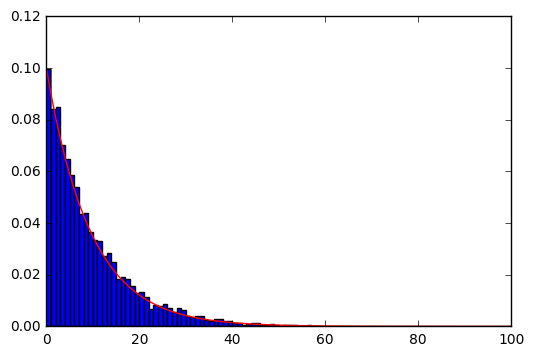

In [31]:
hist(seq_geom, 100, normed=1, range=(0, 100))
xs = np.linspace(0, 100, 101)
p = 0.1
q = 1 - p
ys = [p * q ** x for x in xs]
plot(xs, ys, 'r')

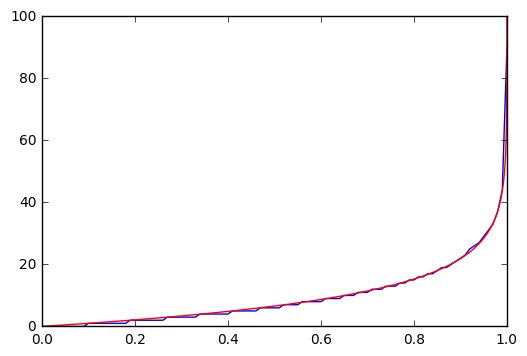

In [32]:
xs = np.linspace(0, 1, 101)
ys = np.percentile(seq_geom, xs * 100)
plot(xs, ys)
xs = np.linspace(0, 100, 101)
ys = [1 - q ** x for x in xs]
plot(ys, xs, 'r')

In [33]:
%time seq_gauss = array(list(islice(cg_g.gen(), 10000)))
print(seq_gauss.mean(), seq_gauss.std())

CPU times: user 11.9 s, sys: 207 ms, total: 12.1 s
Wall time: 11.8 s
0.00128199606316 0.997675553107


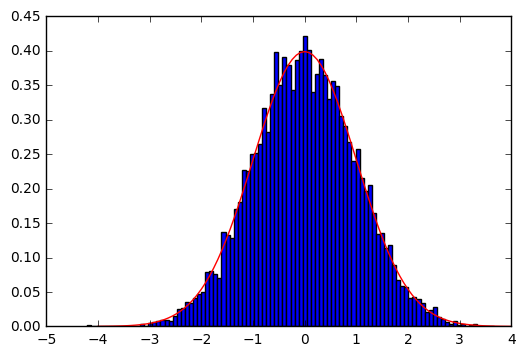

In [34]:
hist(seq_gauss, 100, normed=True)
xs = np.linspace(-4, 4, 101)
sigma = 1
mu = 0
ys = [1 / sqrt(2 * sigma ** 2 * pi) * e ** (-(x - mu) ** 2 / (2 * sigma ** 2)) for x in xs]
plot(xs, ys, 'r')

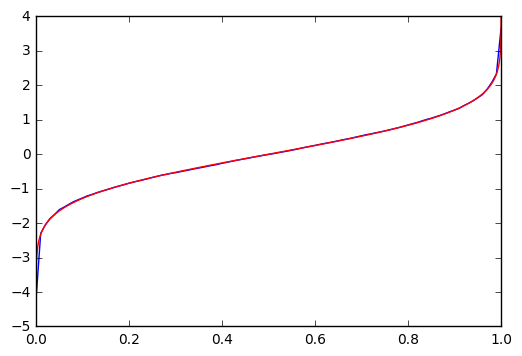

In [35]:
xs = np.linspace(0, 1, 101)
ys = np.percentile(seq_gauss, xs * 100)
plot(xs, ys)
xs = np.linspace(-4, 4, 101)
ys = 0.5 * (1 + erf(sqrt(0.5) * (xs - mu) / sigma))
plot(ys, xs, 'r')

In [36]:
%time seq_gamma = array(list(islice(gamma_g.gen(), 10000)))
print(seq_gamma.mean(), seq_gamma.std())

CPU times: user 23.5 s, sys: 287 ms, total: 23.7 s
Wall time: 23.3 s
2.02138494804 1.43664239286


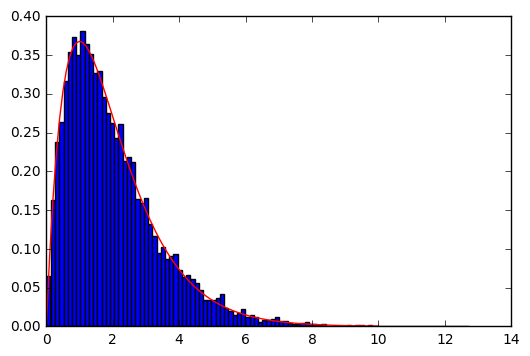

In [47]:
hist(seq_gamma, 100, normed=1)
xs = np.linspace(0, 10, 101)
k = 2
theta = 1
ys = [x ** (k - 1) * e ** (-x / theta) / (theta ** k * gamma(k)) for x in xs]
plot(xs, ys, 'r')

In [46]:
from scipy.special import gamma
gamma

<ufunc 'gamma'>

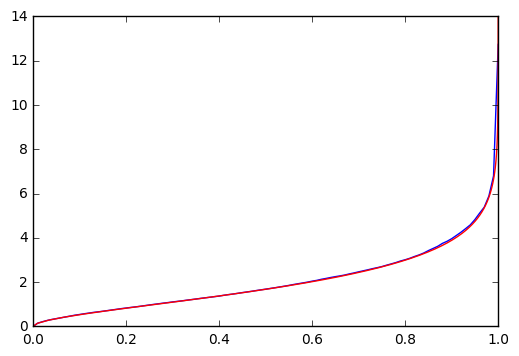

In [48]:
xs = np.linspace(0, 1, 101)
ys = np.percentile(seq_gamma, xs * 100)
plot(xs, ys)
xs = np.linspace(0, 14, 101)
ys = gammainc(k, xs / theta)
plot(ys, xs, 'r')

In [65]:
def count_group_freqs(seq, thresholds):
    thresholds = array(thresholds)
    seq = array(seq)
    counts = sum(seq.reshape((-1, 1)) <= thresholds, axis=0)
    counts = concatenate(([0], counts, [seq.size]))
    return (counts[1:] - counts[:-1])

In [50]:
def compute_geom_probs(thresholds, p):
    q = 1 - p
    cum_probs = [1 - q ** (n + 1) for n in thresholds]
    ex_probs = concatenate(([0], cum_probs, [1]))
    probs = ex_probs[1:] - ex_probs[:-1]
    return probs

In [51]:
compute_geom_probs([0, 1, 2, 5, 10, 20, 50], 0.1)

array([ 0.1       ,  0.09      ,  0.081     ,  0.197559  ,  0.2176304 ,
        0.20439161,  0.10478059,  0.0046384 ])

In [52]:
def chi_square(probs_expected, freqs_computed):
    n = sum(freqs_computed)
    k = len(freqs_computed) - 1
    probs_computed = freqs_computed / n
    chi = n * sum(((probs_expected - probs_computed) ** 2 / probs_expected))
    return gammaincc(k / 2, chi / 2)

### geom

In [66]:
geom_thresholds = [0, 1, 2, 5, 10, 20, 40]
freqs = count_group_freqs(seq_geom, geom_thresholds)
probs_expected = compute_geom_probs(geom_thresholds, 0.1)

In [67]:
chi_square(probs_expected, freqs)

0.24744211674728522

### gauss

In [55]:
def compute_gauss_probs(thresholds, sigma=1, mu=0):
    cum_probs = [0.5 * (1 + erf((x - mu) / (sigma * sqrt(2))) ) for x in thresholds]
    ex_probs = concatenate(([0], cum_probs, [1]))
    probs = ex_probs[1:] - ex_probs[:-1]
    return probs

In [56]:
gauss_thresholds = np.linspace(-2.5, 2.5, 6)
freqs = count_group_freqs(seq_gauss, gauss_thresholds)
probs_expected = compute_gauss_probs(gauss_thresholds)

In [57]:
freqs / sum(freqs) - probs_expected

array([-0.00130967, -0.00069754,  0.00676966, -0.00752492,  0.00226966,
        0.00030246,  0.00019033])

In [58]:
chi_square(probs_expected, freqs)

0.36919841690371552

### gamma

In [59]:
def compute_gamma_probs(thresholds, k, theta):
    cum_probs = [gammainc(k, x / theta) for x in thresholds]
    ex_probs = concatenate(([0], cum_probs, [1]))
    probs = ex_probs[1:] - ex_probs[:-1]
    return probs

In [68]:
#gamma_thresholds = array([0.01, 0.05, 0.2, 0.5, 1, 2])
gamma_thresholds = array([0.5, 1.0, 1.5, 2.0, 3.0, 4.0])
freqs = count_group_freqs(seq_gamma, gamma_thresholds)
probs_expected = compute_gamma_probs(gamma_thresholds, 2, 1)

In [69]:
probs_expected

array([ 0.09020401,  0.17403711,  0.17793348,  0.15181955,  0.20685758,
        0.10757008,  0.09157819])

In [70]:
chi_square(probs_expected, freqs)

0.0

# LAB4

$$
\int_2^{\infty} \frac{\tan(\frac 1x)}{x^2 + x - 3} dx 
= -\int_{0.5}^0 \frac{\tan(t)}{(\frac 1t)^2 + (\frac 1t) - 3} \frac{dt}{t^2}
= \int_0^{0.5} \frac{\tan(t)}{1 + t - 3 t^2} dt
$$

In [108]:
def monte_carlo_int(bounds, g, u_gen, n_iter = 1000):
    n_dims = len(bounds)
    bounds = array(bounds)
    result = 0.0
    inv_density = product(bounds[:, 1] - bounds[:, 0])
    for i in range(n_iter):
        xs = bounds[:, 0] + array(list(islice(u_gen.gen(), n_dims))) * (bounds[:, 1] - bounds[:, 0])
        result += g(xs)
    return result * inv_density / n_iter

In [109]:
uniform_g = UniformWrapper(ssg, bits_per_num=24)

In [110]:
g1 = lambda ts: tan(ts[0]) / (1 + ts[0] - 3 * ts[0] ** 2)
bounds1 = [[0, 0.5]]

In [122]:
%time monte_carlo_int(bounds1, g1, uniform_g, n_iter=100000)

CPU times: user 1min 52s, sys: 1.38 s, total: 1min 54s
Wall time: 1min 52s


0.13812285784333952

In [124]:
g2 = lambda xs: (xs[0] + 4) / (xs[0] ** 2 + xs[1] ** 4 + 1)
bounds2 = [[-4, 3], [-3, 4]]

In [125]:
%time monte_carlo_int(bounds2, g2, uniform_g, n_iter=100000)

CPU times: user 4min 5s, sys: 927 ms, total: 4min 6s
Wall time: 4min 5s


25.967025973710637

# Система

In [151]:
with open('system.txt', 'r') as fin:
    A = []
    for line in fin:
        if not(line.strip()):
            break
        A.append([float(x) for x in line.split()])
    A = array(A)
    f = array([[float(x)] for x in fin.readline().split()])

In [166]:
def particle_markov_step(i, p, u_gen):
    thresholds = cumsum(p[i])
    seed = u_gen.next()
    return sum(thresholds < seed)

In [154]:
def monte_carlo_solve(A, f, u_gen):
    xs = []
    pi = np.ones_like(f) / float(f.size)
    p = np.ones_like(A) / float(A.size)
    g__ = A / p
    for j in len(A):
        h = np.zeros((len(A), 1))
        h[j] = 1
        g_ = h / pi
        Q_0 = g[i][0]
        state = 

In [175]:
m = array([
        [0.1, 0.2, 0.7],
        [0.9, 0.09, 0.01],
        [0.3, 0.3, 0.4]
    ])